<a href="https://colab.research.google.com/github/ChizobaNzeakor/PURPLE-LAGOS/blob/main/Copy_of_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything Model for Geospatial Data

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/satellite.ipynb)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/satellite.ipynb)

This notebook shows how to use segment satellite imagery using the Segment Anything Model (SAM) with a few lines of code.

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.


In [22]:
!pip install segment-geospatial
!pip install folium

## Import libraries

In [23]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps

## Create an interactive map

In [ ]:
m = leafmap.Map(center=[6.5945, 3.3779], zoom=19)
m.add_basemap("SATELLITE")
m

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [25]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [3.28025, 6.59811, 3.29025, 6.60811]

## Download map tiles

Download maps tiles and mosaic them into a single GeoTIFF file

In [26]:
image = "satellite.tif"

Besides the `satellite` basemap, you can use any of the following basemaps returned by the `get_basemaps()` function:

In [27]:
# get_basemaps().keys()

Specify the basemap as the source.

In [28]:
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source="Satellite", overwrite=True)

Downloaded image 001/900
Downloaded image 002/900
Downloaded image 003/900
Downloaded image 004/900
Downloaded image 005/900
Downloaded image 006/900
Downloaded image 007/900
Downloaded image 008/900
Downloaded image 009/900
Downloaded image 010/900
Downloaded image 011/900
Downloaded image 012/900
Downloaded image 013/900
Downloaded image 014/900
Downloaded image 015/900
Downloaded image 016/900
Downloaded image 017/900
Downloaded image 018/900
Downloaded image 019/900
Downloaded image 020/900
Downloaded image 021/900
Downloaded image 022/900
Downloaded image 023/900
Downloaded image 024/900
Downloaded image 025/900
Downloaded image 026/900
Downloaded image 027/900
Downloaded image 028/900
Downloaded image 029/900
Downloaded image 030/900
Downloaded image 031/900
Downloaded image 032/900
Downloaded image 033/900
Downloaded image 034/900
Downloaded image 035/900
Downloaded image 036/900
Downloaded image 037/900
Downloaded image 038/900
Downloaded image 039/900
Downloaded image 040/900


You can also use your own image. Uncomment and run the following cell to use your own image.

In [29]:
# image = '/content/satellite.tif'

Display the downloaded image on the map.

In [30]:
m.layers[-1].visible = False  # turn off the basemap
m.add_raster(image, layer_name="Image")
m

Map(center=[6.60311, 3.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

![](https://i.imgur.com/KAm84IY.png)

## Initialize SAM class

In [31]:
import pandas as pd
from samgeo import SamGeo

sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

## Segment the image

Set `batch=True` to segment the image in batches. This is useful for large images that cannot fit in memory.

In [32]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

# --- Replace these placeholders with your actual image data and metadata ---
# Example image data (e.g., a simple 3-band RGB image)
# This should be a NumPy array with shape (bands, height, width)
# For example, if you have an image loaded as 'img_data' from another source
image_data = np.random.randint(0, 256, size=(3, 256, 256), dtype=np.uint8)

# Output file path
output_filepath = "my_saved_image.tif"

# GeoTIFF metadata (you need to define these based on your image)
# For demonstration, creating dummy metadata.
# In a real scenario, you would extract this from an existing geospatial image
# or define it based on your data source.

# For example, if your top-left corner is at (longitude=10, latitude=20)
# and each pixel is 1 degree by 1 degree:
# transform = from_origin(west, north, x_size, y_size)
transform = from_origin(10.0, 20.0, 1.0, 1.0)

# Coordinate Reference System (CRS) - e.g., WGS84 for latitude/longitude
# You might use 'EPSG:4326' for WGS84
crs = 'EPSG:4326'

# Number of bands in your image
num_bands = image_data.shape[0]

# Height and width of your image
height = image_data.shape[1]
width = image_data.shape[2]

# Data type of your image pixels
dtype = image_data.dtype
# -------------------------------------------------------------------------

# Save the image to a GeoTIFF file
with rasterio.open(
    output_filepath,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,
    dtype=dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(image_data)

print(f"Image successfully saved to {output_filepath}")

Image successfully saved to my_saved_image.tif


In [33]:
mask = "segment.tif"
image = "/content/my_saved_image.tif" # Example: if your image is in a 'data' folder
sam.generate(
    image, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|██████████| 1/1 [06:58<00:00, 418.75s/it]


## Polygonize the raster data

Save the segmentation results as a GeoPackage file.

In [34]:
from samgeo import SamGeo

# Initialize the SamGeo object
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth", # Ensure this path is correct if you're using a specific checkpoint
    sam_kwargs=None,
)

# Define your mask (input raster) and vector (output GeoPackage) file paths
mask = "segment.tif" # This should be the path to your raster mask generated previously
vector = "segment.gpkg"

# Polygonize the raster data
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

print(f"Raster data from {mask} successfully polygonized to {vector}")

Raster data from segment.tif successfully polygonized to segment.gpkg


You can also save the segmentation results as any vector data format supported by GeoPandas.

In [35]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
    "opacity": 1,
}
# Ensure 'm' is defined before this line.
# If you ran the cell where 'm' is created earlier, it should be defined.
# If not, uncomment the lines above to re-initialize 'm' or run the earlier cell.
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(center=[6.60311, 3.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

## Visualize the results

In [36]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(center=[6.60311, 3.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [37]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

In [ ]:
sam.generate(
    image, mask, batch=True, foreground=True,
    erosion_kernel=(3, 3), mask_multiplier=255
)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

In [ ]:
shapefile = "segment.shp"
sam.tiff_to_vector(mask, shapefile)

In [ ]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

![](https://i.imgur.com/Ysq3u7E.png)

In [ ]:
!pip install segment-geospatial

In [ ]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [ ]:
m = leafmap.Map(center=[6.5945, 3.3779], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [3.28025, 6.59811, 3.29025, 6.60811]

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

In [ ]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

In [ ]:
sam.show_masks(cmap="binary_r")

In [ ]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

In [ ]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [ ]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [17]:
sam.generate(image, output="masks2.tif", foreground=True)

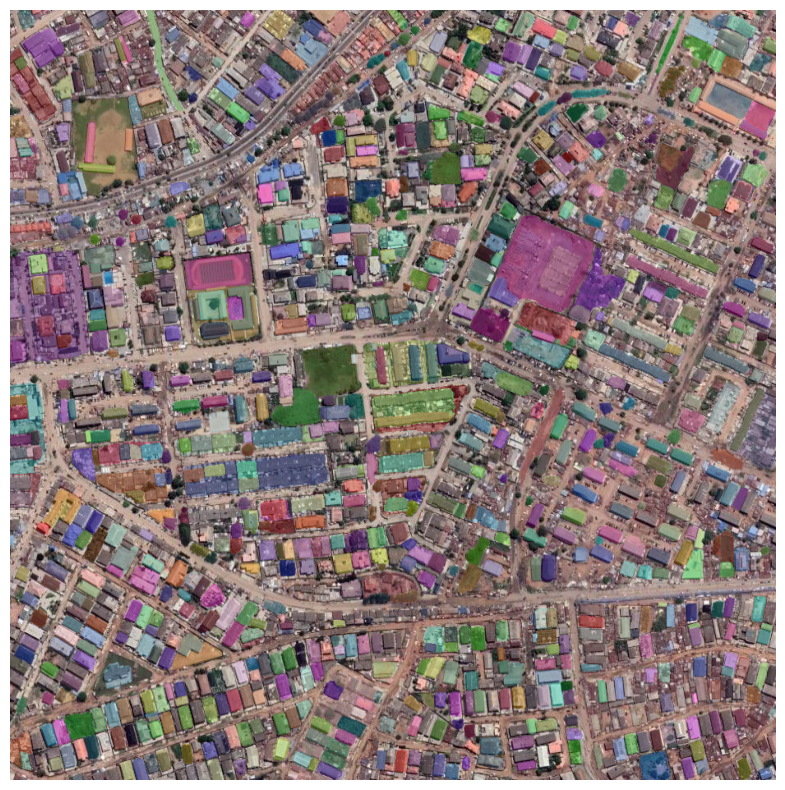

In [18]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")


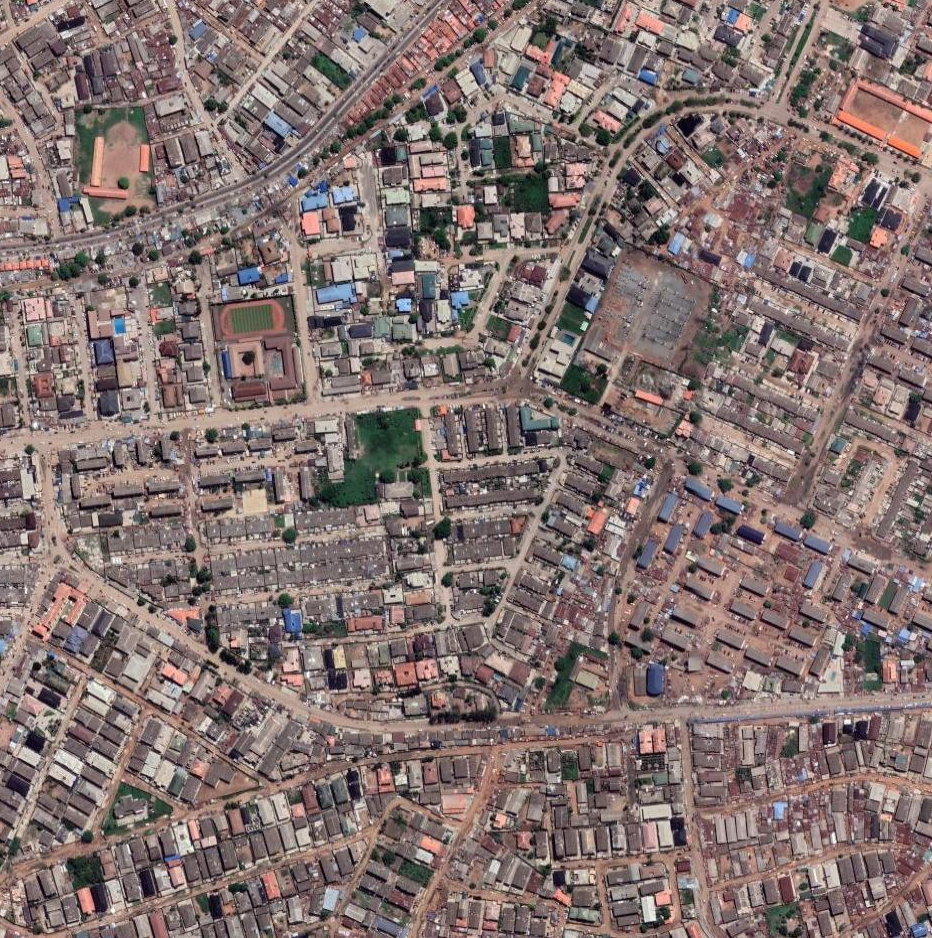
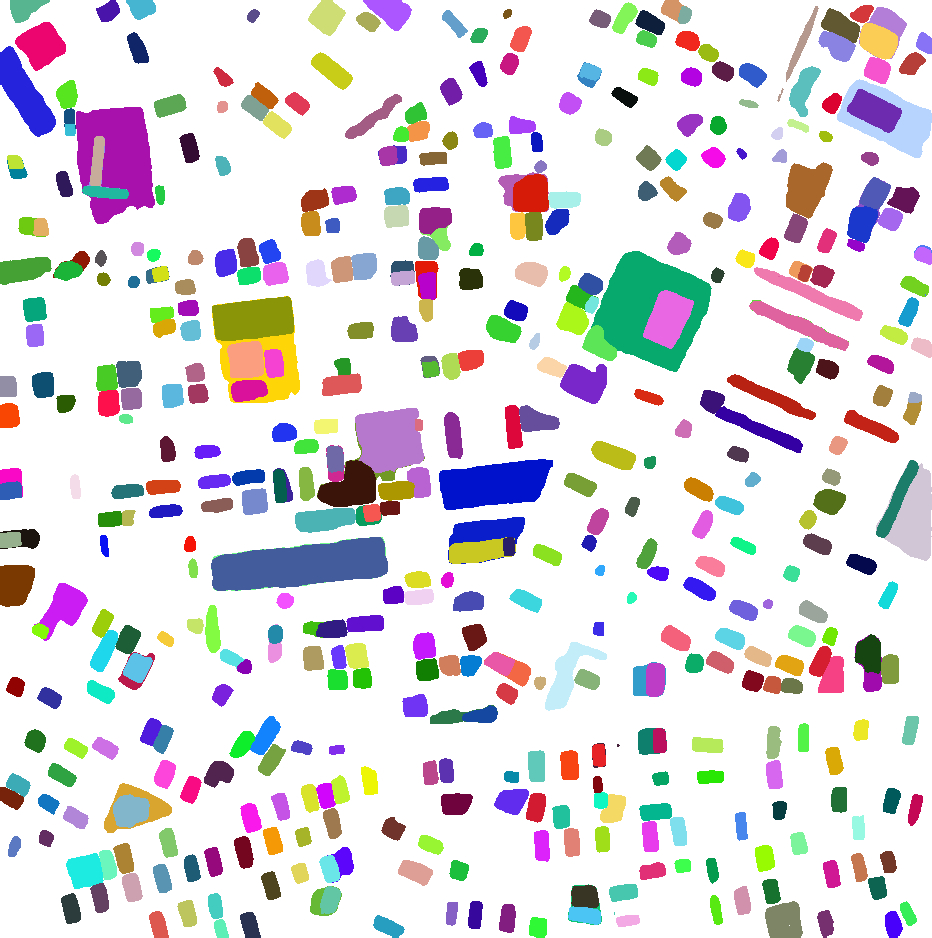

In [19]:
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)

In [20]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=4040501.0, center=[6.60311, 3.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

In [21]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.
